In [1]:
import time
import sys
import logging
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from imutils import face_utils
from face_utilities import Face_utilities
from signal_processing import Signal_processing

logging.basicConfig(level=logging.INFO)

In [2]:
import tempfile
import copy
import traceback
from pyPPG import PPG, Fiducials
from pyPPG.datahandling import load_data
import pyPPG.fiducials as FP

import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import filtfilt, tf2zpk, freqz, cheby2, firwin
from scipy.signal import kaiserord, firwin, filtfilt, detrend, periodogram, lfilter, find_peaks, firls, resample
from dotmap import DotMap


def plot_pole_zero(b, a, title: str = 'Pole-Zero Plot') -> None:
    z, p, k = tf2zpk(b, a)

    plt.figure(figsize=(8, 8))
    plt.scatter(np.real(z), np.imag(z), marker='o', color='blue', label='Zeros')
    plt.scatter(np.real(p), np.imag(p), marker='x', color='red', label='Poles')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

    plt.title(title)
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.grid()
    plt.legend()
    plt.show()


def plot_bode(b, a, fs, title: str = 'Bode Plot') -> None:
    nyq_rate = fs/2
    w, h = freqz(b, a, worN=8000)
    #plt.plot((w/np.pi)*nyq_rate, np.log10(abs(h)), linewidth=2)

    # Magnitude plot
    plt.subplot(2, 1, 1)
    f = (w/np.pi)*nyq_rate
    plt.semilogx(f, np.log10(abs(h)), color='blue')
    plt.title(f'{title} - Magnitude Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Phase plot
    plt.subplot(2, 1, 2)
    plt.semilogx(f, np.angle(h, deg=True), color='red')
    plt.title('Phase Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase [degrees]')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Display the plot
    plt.tight_layout()
    plt.show()


def detect_peaks(signal) -> pd.DataFrame:
    signal.vpg = np.gradient(signal.ppg)
    signal.apg = np.gradient(signal.vpg)
    signal.jpg = np.gradient(signal.apg)
    s = PPG(s=signal, check_ppg_len=True)

    corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
    correction=pd.DataFrame()
    correction.loc[0, corr_on] = True
    signal.correction=correction

    # Extract fiducial points
    fpex = FP.FpCollection(s=s)

    # This fails:
    # fiducials = fpex.get_fiducials(s=s)
    # This is the error (I think it' because our framerate is too low):
    # ValueError                                Traceback (most recent call last)
    # Cell In[31], line 31
    #      29 ppg_fp=pd.DataFrame()
    #      30 peaks, onsets = fpex.get_peak_onset(peak_detector)
    # ---> 31 dicroticnotch = fpex.get_dicrotic_notch(peaks, onsets)
    # 
    # File ~/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/pyPPG/fiducials.py:815, in FpCollection.get_dicrotic_notch(self, peaks, onsets)
    #     813 f = [0, (FcU / Fn), (FcD / Fn), 1]          # Frequency band edges
    #     814 a = [1, 1, 0, 0]                            # Amplitudes
    # --> 815 b = firls(n, f, a)
    #     817 lp_ppg = filtfilt(b, 1,  dxx)          # Low pass filtered signal with 20 cut off Frequency and 5 Hz Transition width
    #     819 ## The weighting is calculated and applied to each beat individually
    # 
    # File ~/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/scipy/signal/_fir_filter_design.py:981, in firls(numtaps, bands, desired, weight, nyq, fs)
    #     979     raise ValueError("bands must contain frequency pairs.")
    #     980 if (bands < 0).any() or (bands > 1).any():
    # --> 981     raise ValueError("bands must be between 0 and 1 relative to Nyquist")
    #     982 bands.shape = (-1, 2)
    #     984 # check remaining params
    # 
    # ValueError: bands must be between 0 and 1 relative to Nyquist
    ######################################################
    # BEGIN REIMPLEMENTATION OF get_fiducials
    ######################################################
    self = fpex
    
    # Extract Fiducial Points
    ppg_fp=pd.DataFrame()
    peaks, onsets = fpex.get_peak_onset('PPGdet')
    
    ## The 2nd derivative and Hamming low pass filter is calculated.
    dxx = np.diff(np.diff(self.ppg))
    fs = self.fs
    
    # Make filter
    Fn = fs / 2                                 # Nyquist Frequency
    FcU = 10                                    # Cut off Frequency: MODIFIED FROM 20 Hz to 10Hz
    FcD = FcU + 5                               # Transition Frequency: 5 Hz
    
    n = 21                                      # Filter order
    f = [0, (FcU / Fn), (FcD / Fn), 1]          # Frequency band edges
    a = [1, 1, 0, 0]                            # Amplitudes
    b = firls(n, f, a)
    
    lp_ppg = filtfilt(b, 1,  dxx)          # Low pass filtered signal with 20 cut off Frequency and 5 Hz Transition width
    
    ## The weighting is calculated and applied to each beat individually
    def t_wmax(i, peaks,onsets):
        if i < 3:
            HR = np.mean(np.diff(peaks))/fs
            t_wmax = -0.1 * HR + 0.45
        else:
            t_wmax = np.mean(peaks[i - 3:i]-onsets[i - 3:i])/fs
        return t_wmax
    
    dic_not=[]
    for i in range(0,len(onsets)-1):
        nth_beat = lp_ppg[onsets[i]:onsets[i + 1]]
    
        i_Pmax=peaks[i]-onsets[i]
        t_Pmax=(peaks[i]-onsets[i])/fs
        t=np.linspace(0,len(nth_beat)-1,len(nth_beat))/fs
        T_beat=(len(nth_beat)-1)/fs
        tau=(t-t_Pmax)/(T_beat-t_Pmax)
        tau[0:i_Pmax] = 0
        beta=5
    
        if len(peaks)>1:
            t_w=t_wmax(i, peaks, onsets)
        else:
            t_w=np.NaN
    
        if t_w!=T_beat:
            tau_wmax=(t_w-t_Pmax)/(T_beat-t_Pmax)
        else:
            tau_wmax=0.9
    
        alfa=(beta*tau_wmax-2*tau_wmax+1)/(1-tau_wmax)
        if (alfa > 4.5) or (alfa < 1.5):
            HR = np.mean(np.diff(peaks))/fs
            t_w = -0.1 * HR + 0.45
            tau_wmax = (t_w - t_Pmax) / (T_beat - t_Pmax)
            alfa = (beta * tau_wmax - 2 * tau_wmax + 1) / (1 - tau_wmax)
    
        ## Calculate the Dicrotic Notch for each heart cycle using the weighted window
        if alfa>1:
            w = tau ** (alfa - 1) * (1 - tau) ** (beta - 1)
        else:
            w = tau * (1 - tau) ** (beta - 1)
    
        pp=w*nth_beat
        pp = pp[np.where(~np.isnan(pp))]
        max_pp_v = np.max(pp)
        max_pp_i=np.where(pp==max_pp_v)[0][0]
        ## NOTE!! Shifting with 26 ms. FIX IT!
        shift=int(self.fs*0.026)
        dic_not.append(max_pp_i+onsets[i]+shift)
    dicroticnotch = dic_not
    
    vpg_fp = self.get_vpg_fiducials(onsets)
    apg_fp = self.get_apg_fiducials(onsets, peaks)
    jpg_fp = self.get_jpg_fiducials(onsets, apg_fp)
    
    diastolicpeak = self.get_diastolic_peak(onsets, dicroticnotch, apg_fp.e)
    
    # Merge Fiducial Points
    keys=('on', 'sp', 'dn','dp')
    dummy = np.empty(len(peaks))
    dummy.fill(np.NaN)
    n=0
    for temp_val in (onsets,peaks,dicroticnotch,diastolicpeak):
        ppg_fp[keys[n]] = dummy
        ppg_fp[keys[n]][0:len(temp_val)]=temp_val
        n=n+1
    
    fiducials=pd.DataFrame()
    for temp_sig in (ppg_fp,vpg_fp,apg_fp,jpg_fp):
        for key in list(temp_sig.keys()):
            fiducials[key] = dummy
            temp_val = temp_sig[key].values
            fiducials[key][0:len(temp_val)]=temp_val
    
    # Correct Fiducial Points
    fiducials=self.correct_fiducials(fiducials, s.correction)
    
    fiducials=fiducials.astype('Int64')
    
    # Extract pulse offsets
    offsets = copy.deepcopy(fiducials.on[1:])
    offsets.index = offsets.index - 1
    
    # Update index name
    fiducials = fiducials.drop(len(fiducials)-1)
    fiducials = fiducials.rename_axis('Index of pulse')
    
    # Add pulse offsets
    fiducials.insert(4, 'off', offsets)
    ######################################################
    # END REIMPLEMENTATION OF get_fiducials
    ######################################################
    
    return fiducials

def plot_peaks(s, fiducials: pd.DataFrame, title='PPG Peaks'):
    # Insíred by: https://github.com/godamartonaron/GODA_pyPPG/blob/main/pyPPG/datahandling.py#
    # plot_fiducials(s=s, fp=fp, savefig=savefig, show_fig=show_fig, print_flag=print_flag, use_tk=use_tk)

    fp = Fiducials(fp=fiducials)
    marker=[]
    marker_size=60
    marker = ['o', 's', 's','o', 'o', 's', 'o', 'o', 's', 'o', 's', 'o', 's', 'o', 's']
    color = ['r', 'b', 'g','m', 'r', 'b', 'g', 'r', 'b', 'g', 'm', 'c', 'k', 'r', 'b']
    fid_names = ('sp', 'on', 'dn','dp')
    str_sig = 0
    end_sig = len(s.ppg)
    len_sig=end_sig-str_sig
    step_small = 1
    if len_sig/s.fs<10:
        step_big = step_small * 1
    else:
        step_big = step_small * 5
    len_sig_sec=int(len_sig / s.fs)
    if len_sig_sec<1:
        len_sig_sec=1

    major_ticks_names = range(0,len_sig_sec,step_big)
    len_ticks_names=len(major_ticks_names)
    major_diff=len_sig/len_ticks_names
    major_ticks = np.arange(str_sig, end_sig, major_diff)
    major_ticks = major_ticks[0:len_ticks_names]
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.xlabel('Time [s]')
    plt.xticks(major_ticks, major_ticks_names)
    plt.plot(s.ppg, 'k', label=None)
    for n in fid_names:
        ind = fid_names.index(n)
        tmp_pnt=eval("fp." + n + ".values")
        tmp_pnt=tmp_pnt[~np.isnan(tmp_pnt)].astype(int)
        tmp_sig=s.ppg
        plt.scatter(tmp_pnt, tmp_sig[tmp_pnt], s=marker_size,linewidth=2, marker = marker[ind], facecolors='none', color=color[ind], label=n)
    plt.show()

def filter_ppg(s: DotMap, verbose: bool = False) -> np.ndarray:
    # Inspired by: https://github.com/godamartonaron/GODA_pyPPG/blob/main/pyPPG/preproc.py#L6
    fL=0.5000001
    fH=12
    order=4    
    b, a = cheby2(order, 20, [fL,fH], 'bandpass', fs=s.fs)
    ppg_cb2 = filtfilt(b, a, s.v)
    if verbose:
        print('cheby2 a =', a)
        print('cheby2 b =', b)
        plot_bode(b, a, s.fs, title='Bode')
        plot_pole_zero(b, a, title='Pole-zero')
    return ppg_cb2

INFO:root:--------------------------------------------------
INFO:root:
Reading video 1 (15:50:04)


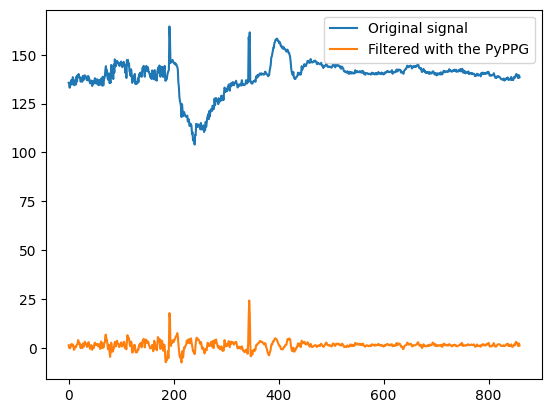

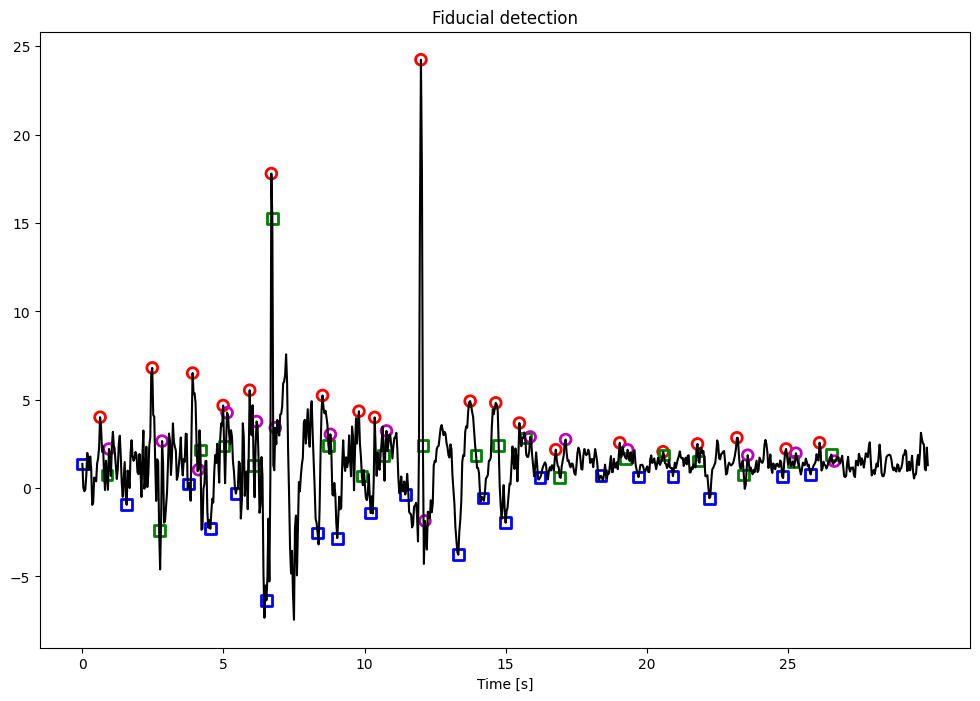

INFO:root:End of video. Total running time: 56.06408405303955
INFO:root:We should have about 900 frames, and we have 860
INFO:root:Final BPM before filtering: 145
INFO:root:Average BPM before filtering: 69
INFO:root:Median BPM after filtering: 73
INFO:root:Real BPM: 100.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 2 (15:53:33)


????????????????


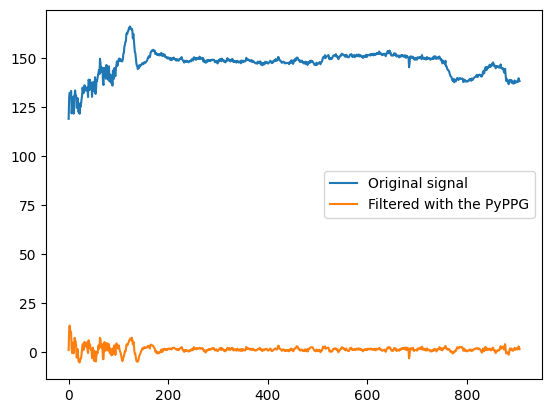

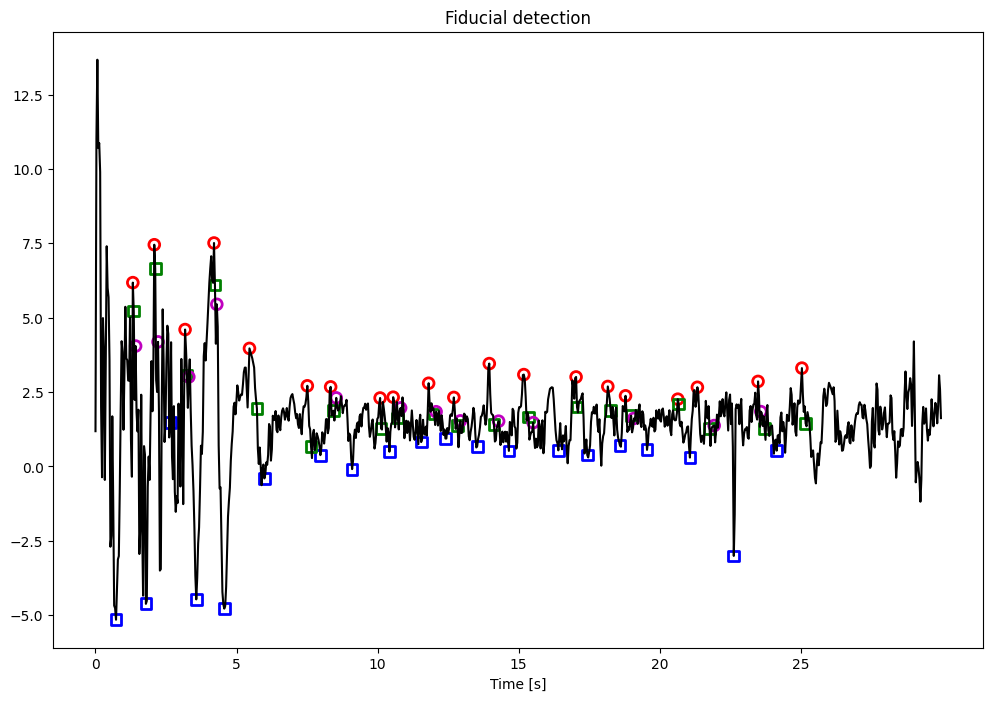

INFO:root:End of video. Total running time: 61.28269338607788
INFO:root:We should have about 900 frames, and we have 907
INFO:root:Final BPM before filtering: 72
INFO:root:Average BPM before filtering: 71
INFO:root:Median BPM after filtering: 73
INFO:root:Real BPM: 101.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 6 (15:55:30)


????????????????


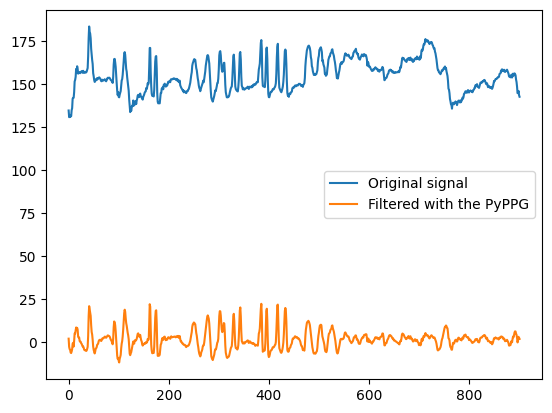

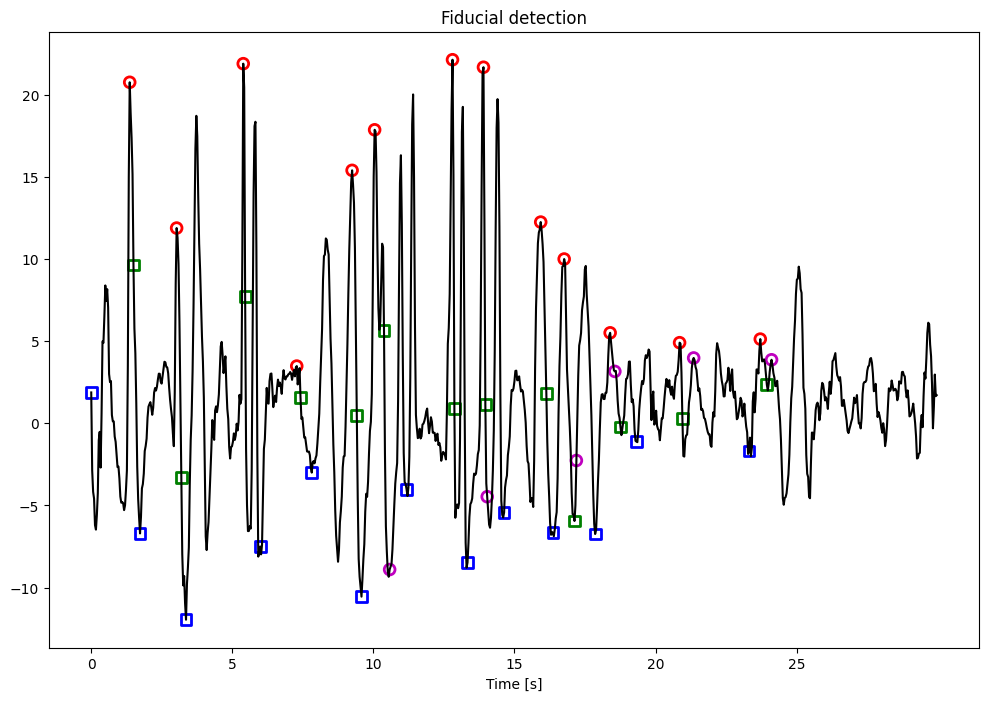

INFO:root:End of video. Total running time: 57.60813236236572
INFO:root:We should have about 900 frames, and we have 902
INFO:root:Final BPM before filtering: 54
INFO:root:Average BPM before filtering: 79
INFO:root:Median BPM after filtering: 114
INFO:root:Real BPM: 129.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 7 (15:58:54)


????????????????


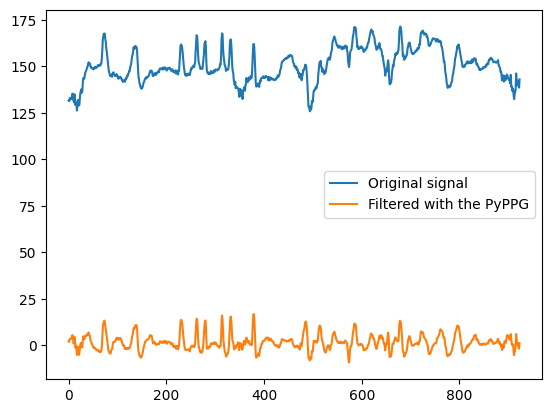

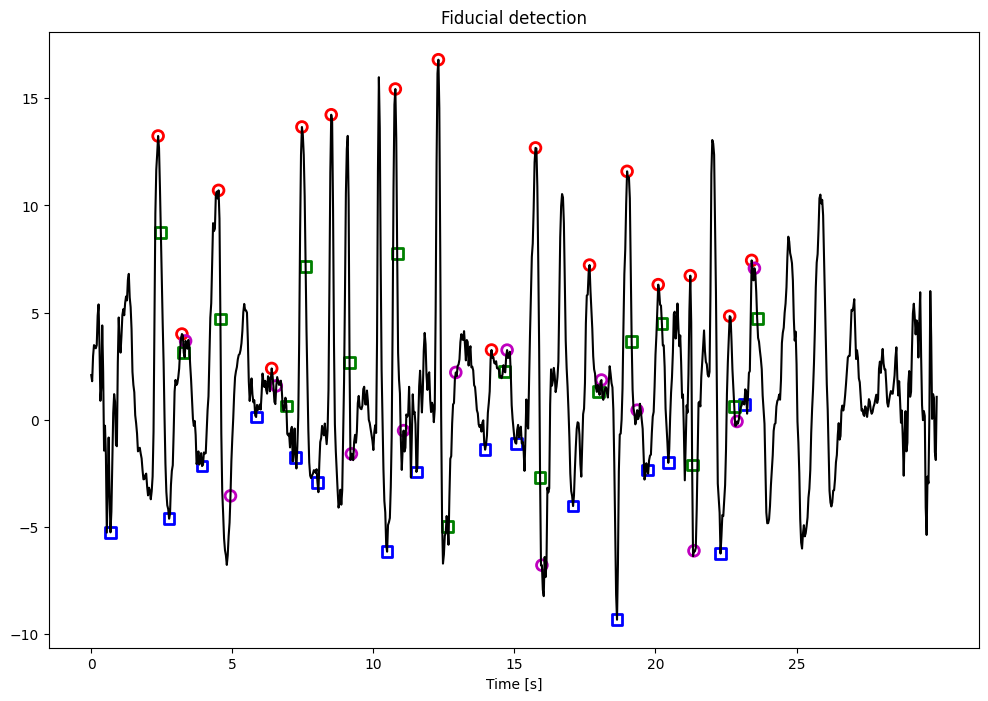

INFO:root:End of video. Total running time: 60.159241914749146
INFO:root:We should have about 900 frames, and we have 924
INFO:root:Final BPM before filtering: 54
INFO:root:Average BPM before filtering: 64
INFO:root:Median BPM after filtering: 81
INFO:root:Real BPM: 128.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 11 (16:00:19)


????????????????


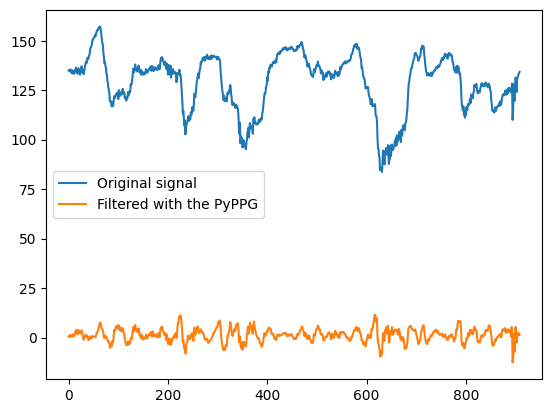

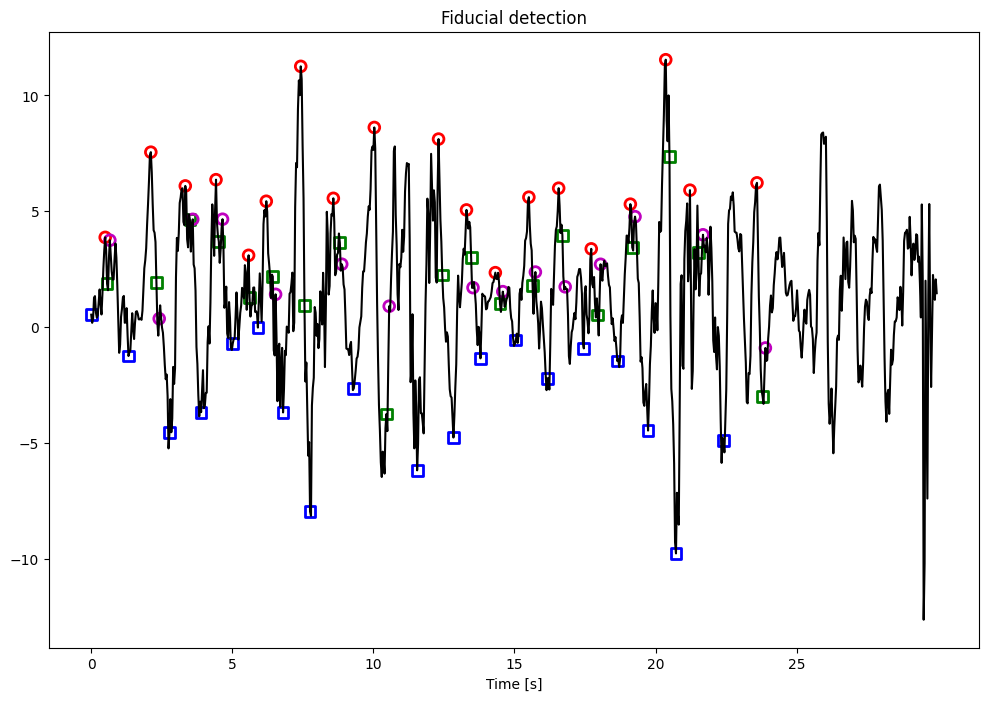

INFO:root:End of video. Total running time: 58.75734353065491
INFO:root:We should have about 900 frames, and we have 909
INFO:root:Final BPM before filtering: 54
INFO:root:Average BPM before filtering: 58
INFO:root:Median BPM after filtering: 70
INFO:root:Real BPM: 140.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 12 (16:01:10)


????????????????


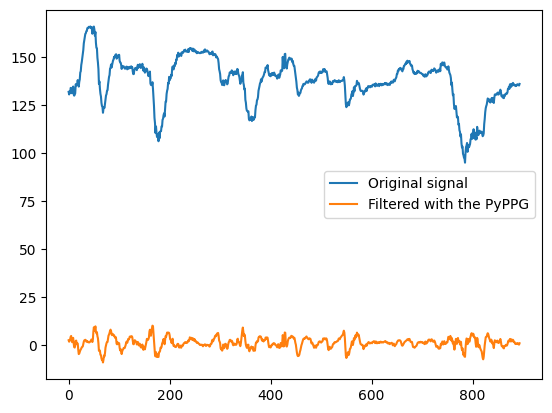

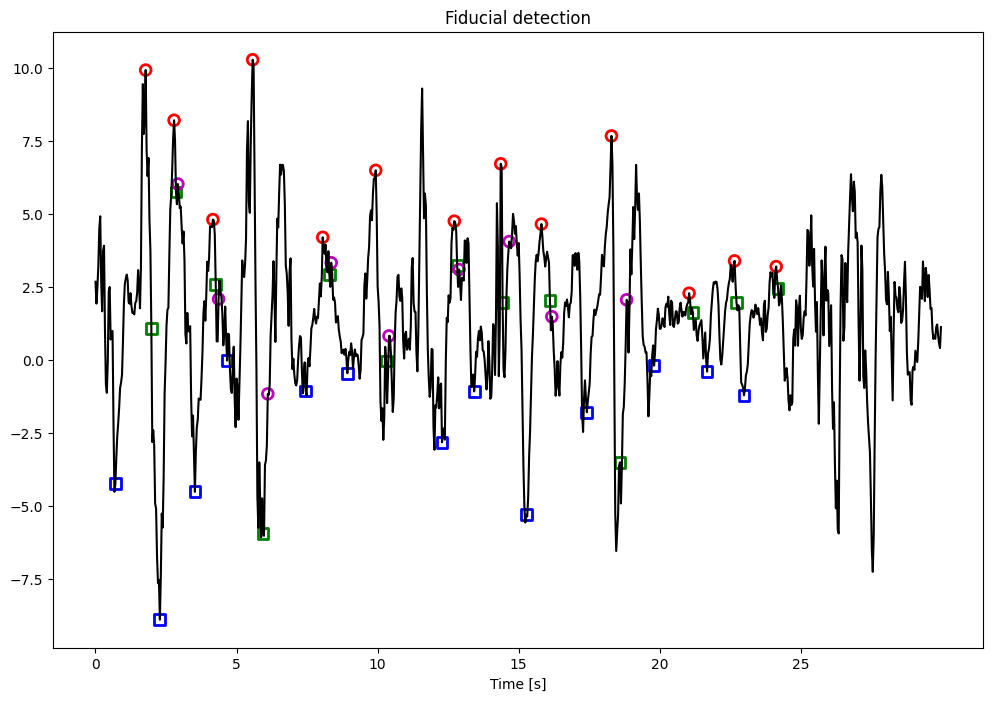

INFO:root:End of video. Total running time: 57.82114386558533
INFO:root:We should have about 900 frames, and we have 894
INFO:root:Final BPM before filtering: 72
INFO:root:Average BPM before filtering: 60
INFO:root:Median BPM after filtering: 96
INFO:root:Real BPM: 143.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 16 (16:02:15)


????????????????


/home/benitez/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/benitez/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


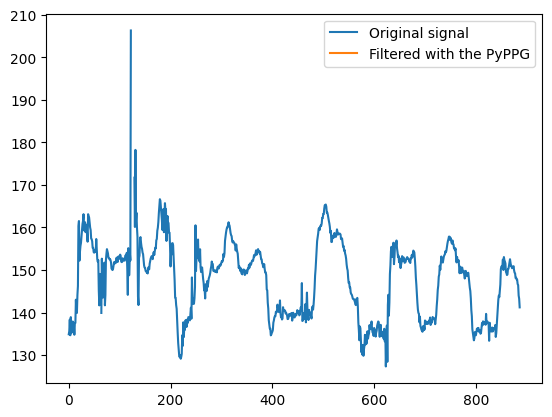

ERROR:root:Excpetion at peak identification: negative dimensions are not allowed, Traceback (most recent call last):
  File "/tmp/ipykernel_87129/796587426.py", line 158, in <module>
    fiducials = detect_peaks(signal)
  File "/tmp/ipykernel_87129/4256704585.py", line 178, in detect_peaks
    vpg_fp = self.get_vpg_fiducials(onsets)
  File "/home/benitez/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/pyPPG/fiducials.py", line 935, in get_vpg_fiducials
    nan_v = np.empty(len(onsets)-1)
ValueError: negative dimensions are not allowed

INFO:root:End of video. Total running time: 57.4700083732605
INFO:root:We should have about 900 frames, and we have 887
INFO:root:Final BPM before filtering: 54
INFO:root:Average BPM before filtering: 62
INFO:root:Median BPM after filtering: 0
INFO:root:Real BPM: 116.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 17 (16:03:30)
/home/benitez/.cache/pypoetry/virtualenv

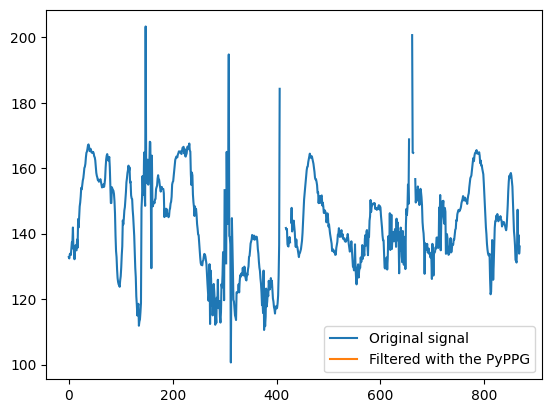

ERROR:root:Excpetion at peak identification: negative dimensions are not allowed, Traceback (most recent call last):
  File "/tmp/ipykernel_87129/796587426.py", line 158, in <module>
    fiducials = detect_peaks(signal)
  File "/tmp/ipykernel_87129/4256704585.py", line 178, in detect_peaks
    vpg_fp = self.get_vpg_fiducials(onsets)
  File "/home/benitez/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/pyPPG/fiducials.py", line 935, in get_vpg_fiducials
    nan_v = np.empty(len(onsets)-1)
ValueError: negative dimensions are not allowed

INFO:root:End of video. Total running time: 56.33746647834778
INFO:root:We should have about 900 frames, and we have 869
INFO:root:Final BPM before filtering: 54
INFO:root:Average BPM before filtering: 60
INFO:root:Median BPM after filtering: 0
INFO:root:Real BPM: 127.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 21 (16:06:11)


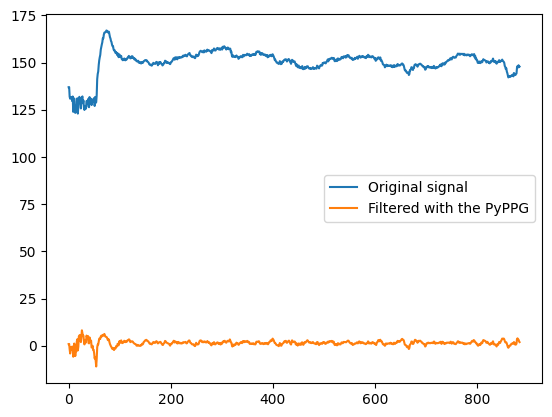

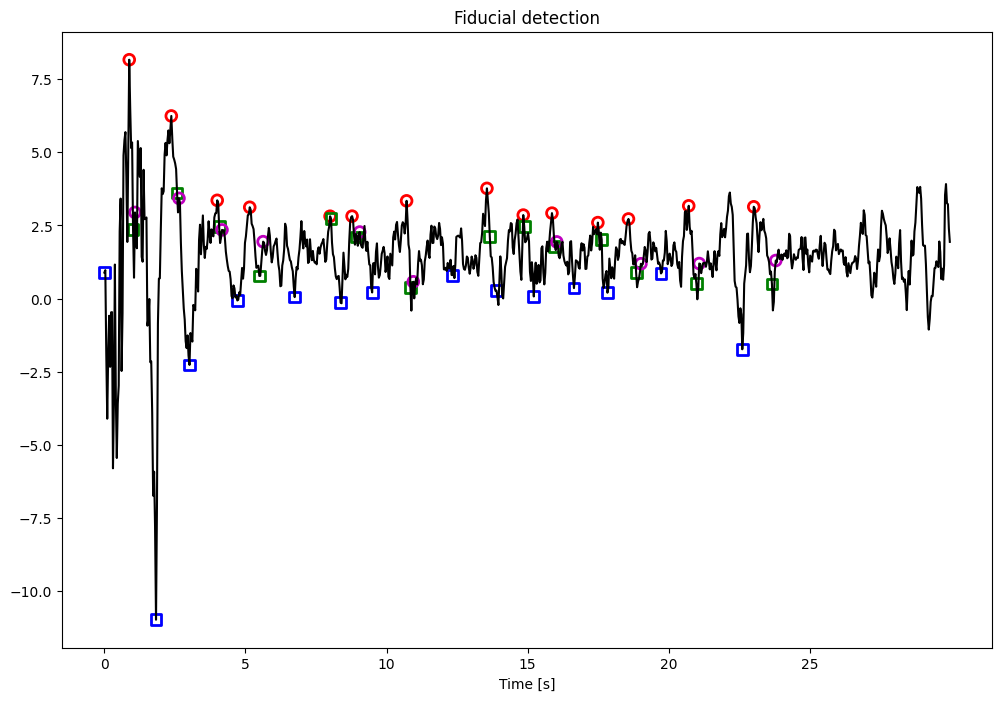

INFO:root:End of video. Total running time: 58.14350700378418
INFO:root:We should have about 900 frames, and we have 885
INFO:root:Final BPM before filtering: 54
INFO:root:Average BPM before filtering: 66
INFO:root:Median BPM after filtering: 95
INFO:root:Real BPM: 137.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 22 (16:07:00)


????????????????


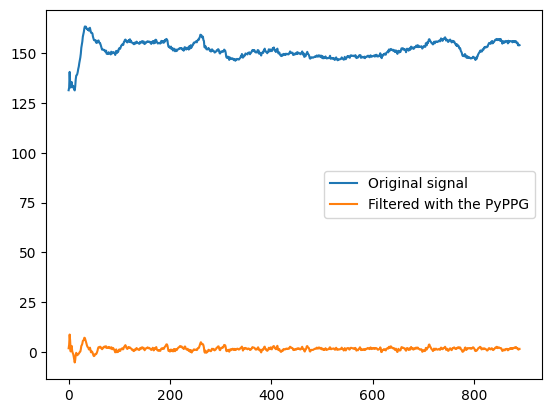

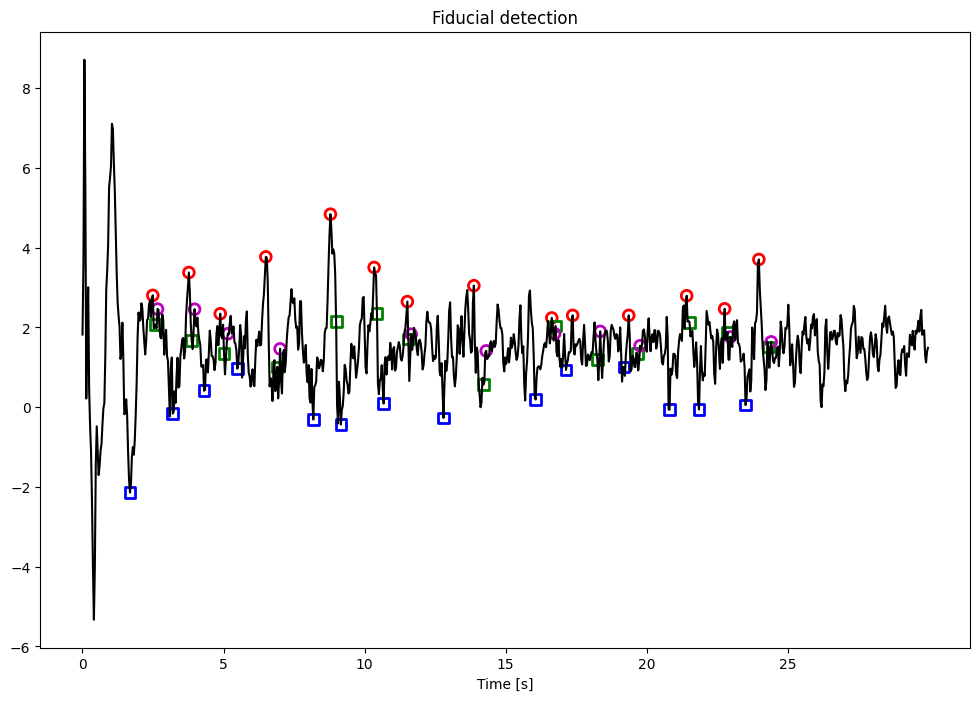

INFO:root:End of video. Total running time: 57.685962438583374
INFO:root:We should have about 900 frames, and we have 891
INFO:root:Final BPM before filtering: 109
INFO:root:Average BPM before filtering: 66
INFO:root:Median BPM after filtering: 91
INFO:root:Real BPM: 128.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 23 (16:18:44)


????????????????


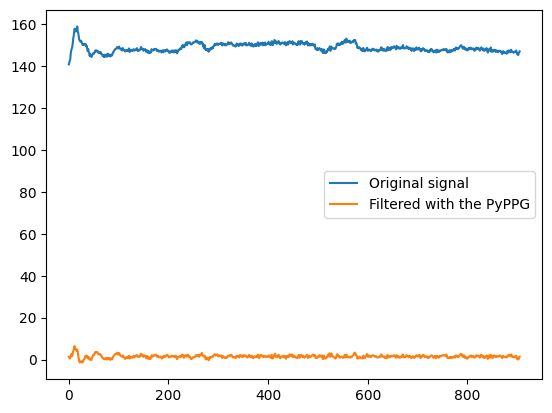

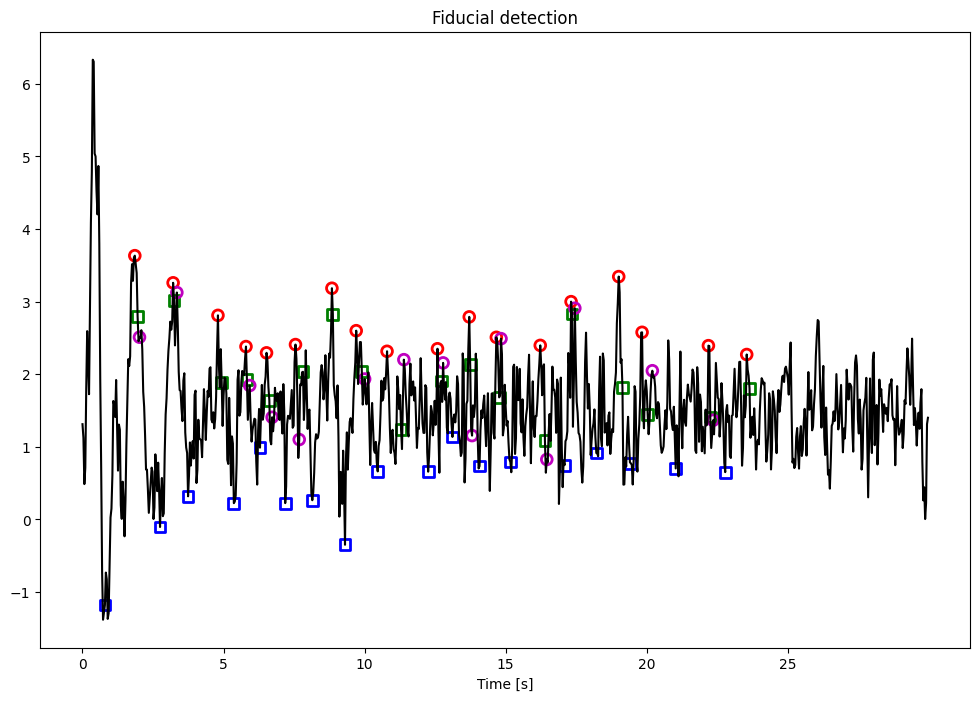

INFO:root:End of video. Total running time: 60.05220317840576
INFO:root:We should have about 900 frames, and we have 906
INFO:root:Final BPM before filtering: 54
INFO:root:Average BPM before filtering: 73
INFO:root:Median BPM after filtering: 67
INFO:root:Real BPM: 107.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 26 (16:08:00)


????????????????


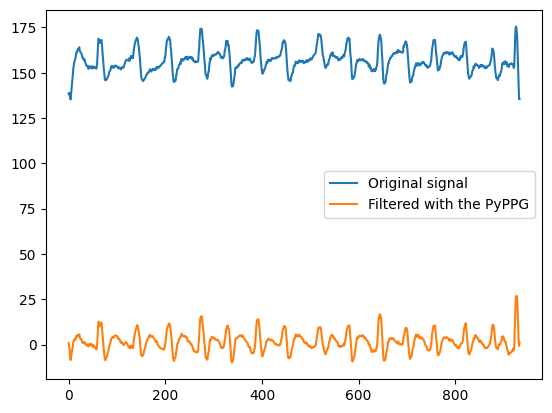

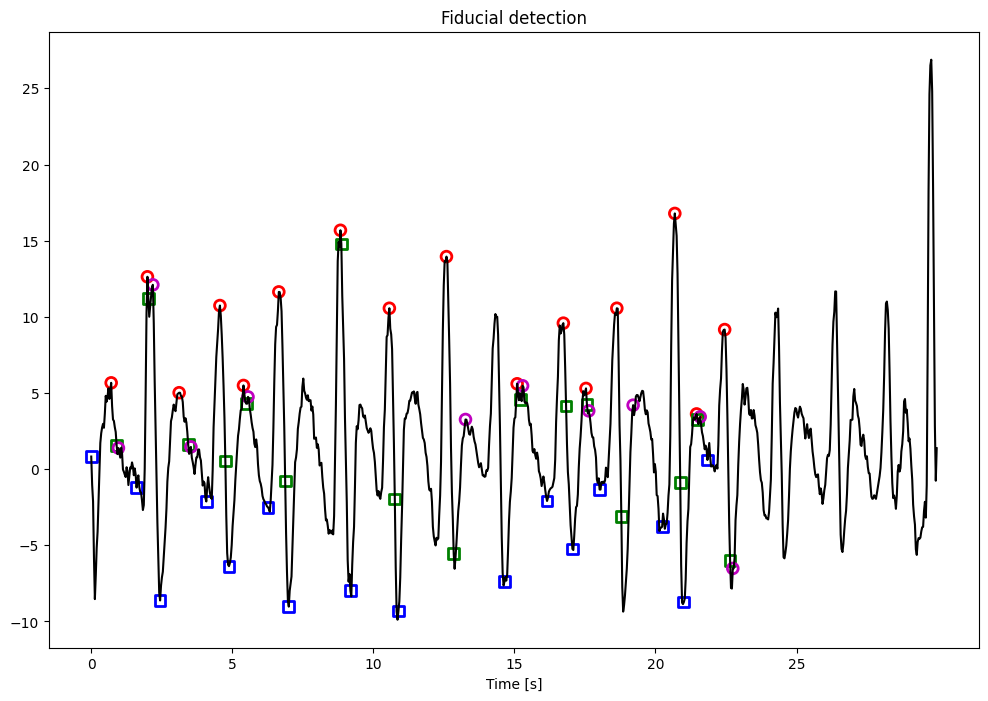

INFO:root:End of video. Total running time: 63.74009943008423
INFO:root:We should have about 900 frames, and we have 934
INFO:root:Final BPM before filtering: 72
INFO:root:Average BPM before filtering: 59
INFO:root:Median BPM after filtering: 79
INFO:root:Real BPM: 134.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 27 (16:09:04)


????????????????


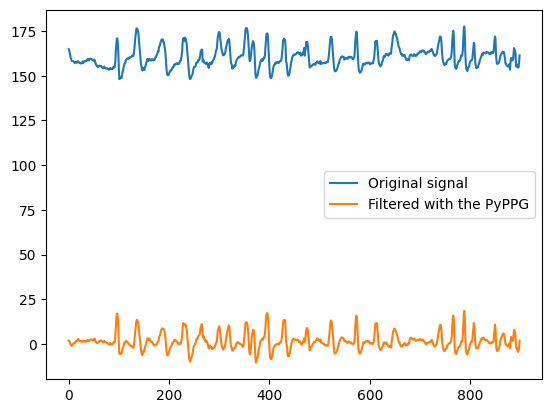

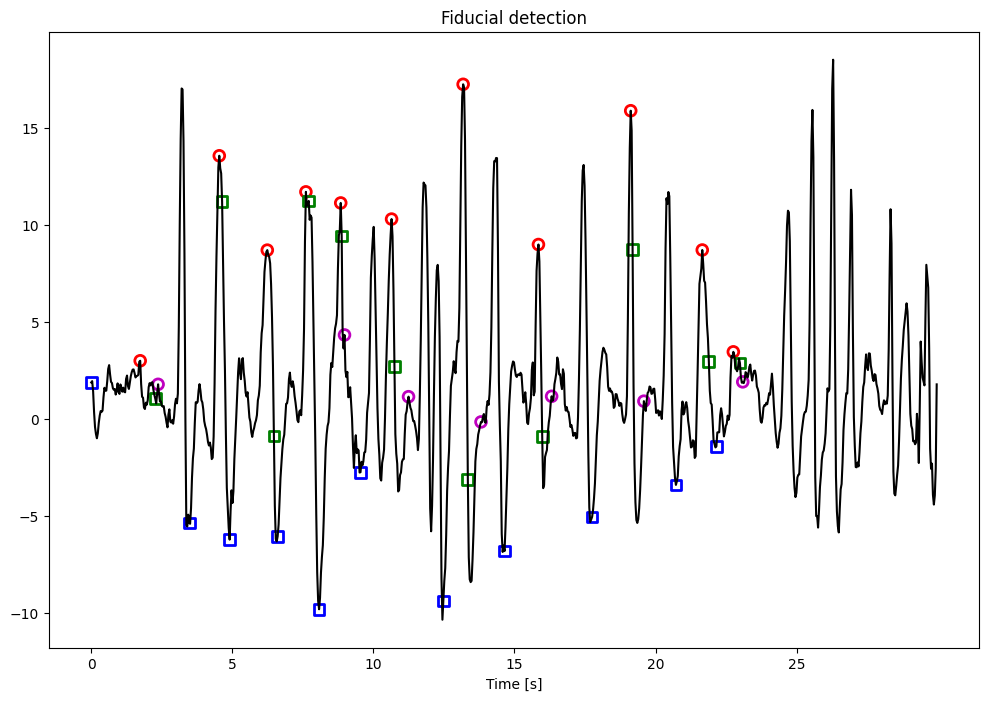

INFO:root:End of video. Total running time: 57.022465467453
INFO:root:We should have about 900 frames, and we have 899
INFO:root:Final BPM before filtering: 90
INFO:root:Average BPM before filtering: 72
INFO:root:Median BPM after filtering: 128
INFO:root:Real BPM: 111.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 28 (16:10:00)


????????????????


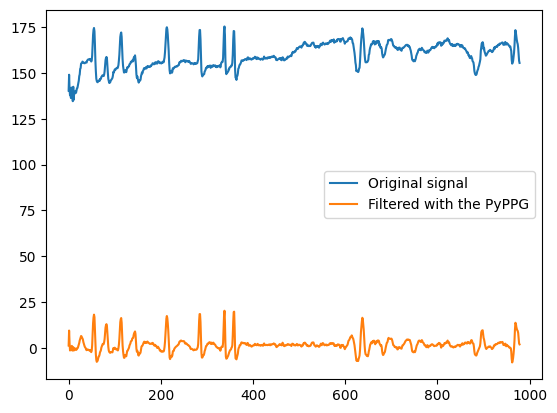

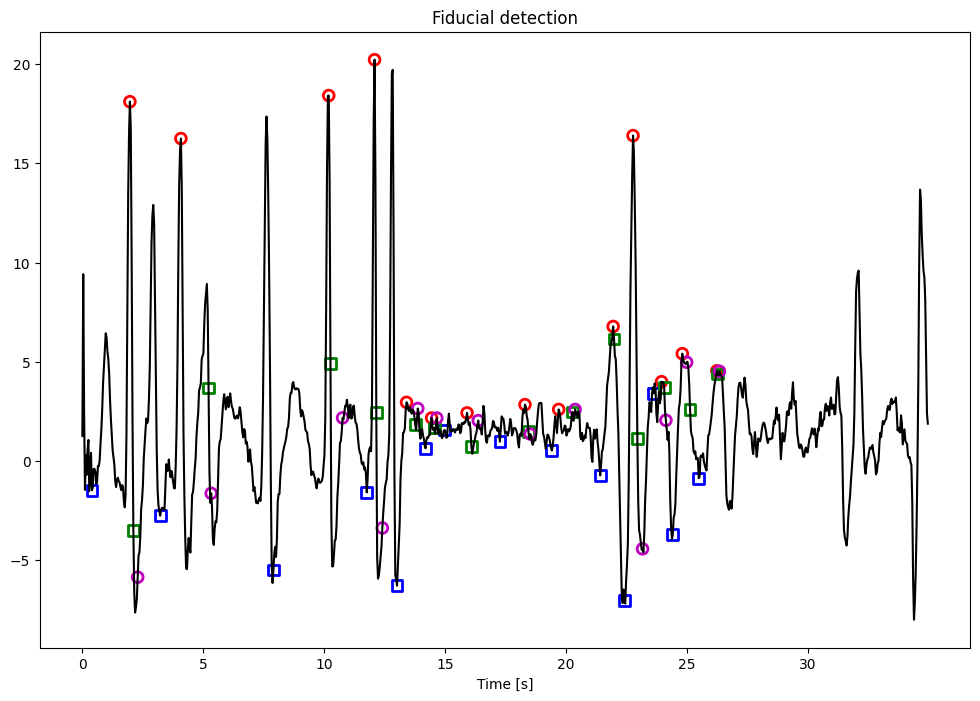

INFO:root:End of video. Total running time: 63.102184534072876
INFO:root:We should have about 900 frames, and we have 979
INFO:root:Final BPM before filtering: 127
INFO:root:Average BPM before filtering: 70
INFO:root:Median BPM after filtering: 79
INFO:root:Real BPM: 105.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 31 (16:12:56)


????????????????


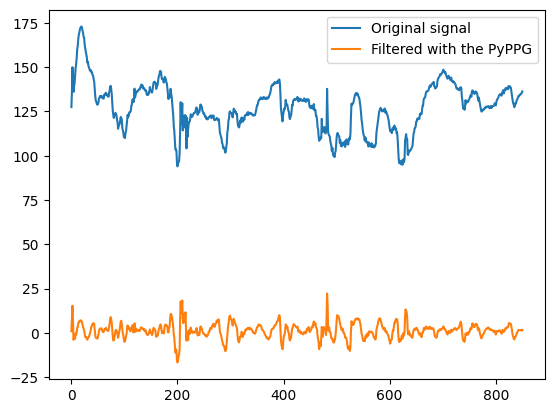

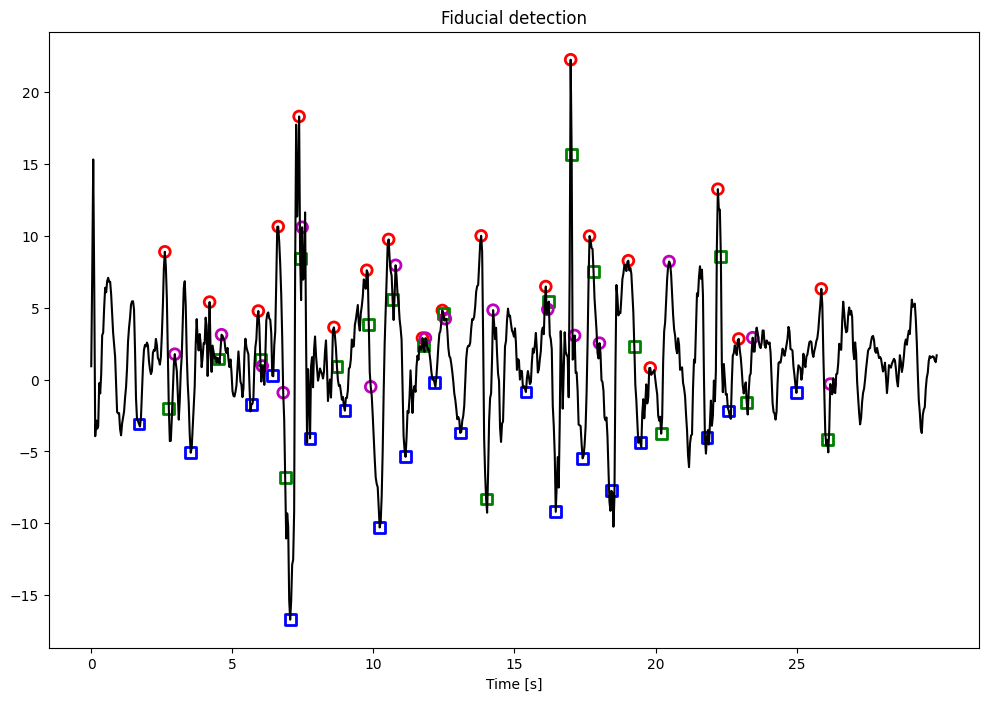

INFO:root:End of video. Total running time: 56.67979454994202
INFO:root:We should have about 900 frames, and we have 851
INFO:root:Final BPM before filtering: 90
INFO:root:Average BPM before filtering: 65
INFO:root:Median BPM after filtering: 66
INFO:root:Real BPM: 126.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 32 (16:13:41)


????????????????


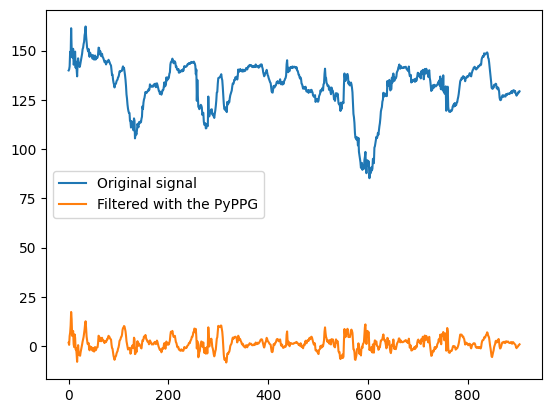

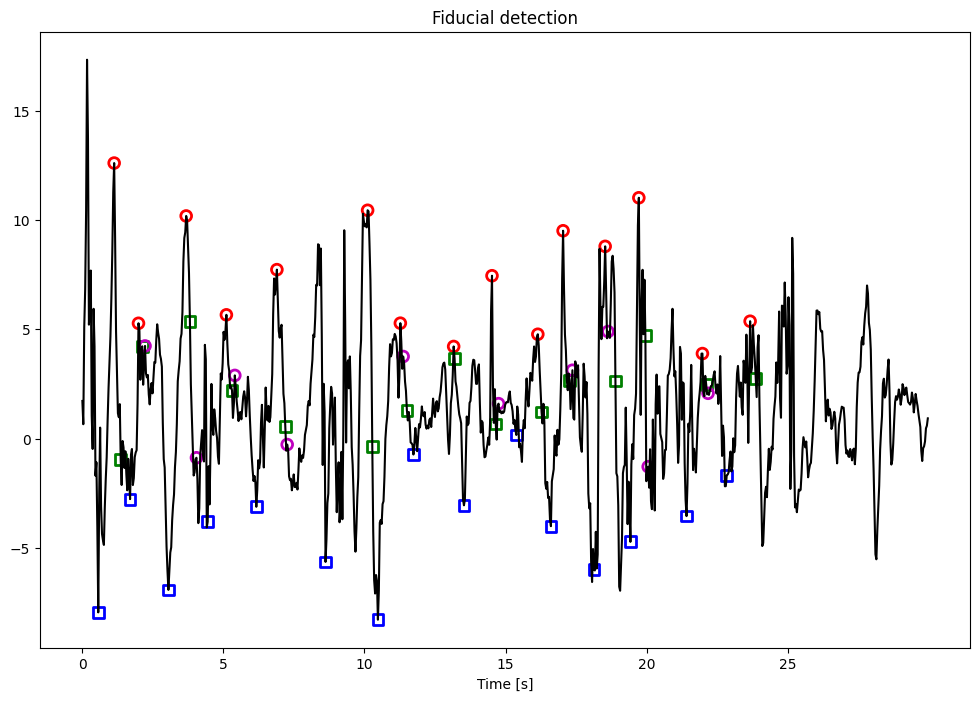

INFO:root:End of video. Total running time: 57.44316840171814
INFO:root:We should have about 900 frames, and we have 905
INFO:root:Final BPM before filtering: 90
INFO:root:Average BPM before filtering: 59
INFO:root:Median BPM after filtering: 93
INFO:root:Real BPM: 116.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 33 (16:14:39)


????????????????


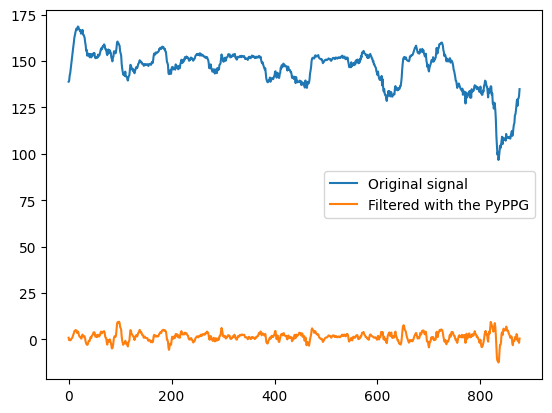

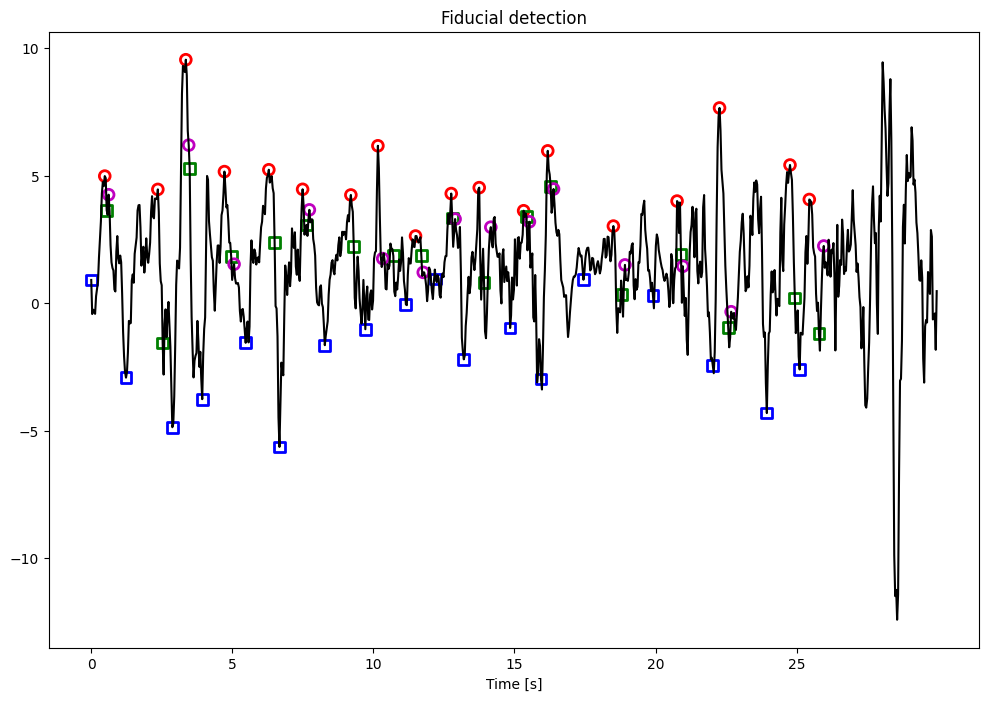

INFO:root:End of video. Total running time: 58.362881660461426
INFO:root:We should have about 900 frames, and we have 877
INFO:root:Final BPM before filtering: 54
INFO:root:Average BPM before filtering: 64
INFO:root:Median BPM after filtering: 79
INFO:root:Real BPM: 145.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 36 (16:15:32)


????????????????


/home/benitez/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/benitez/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


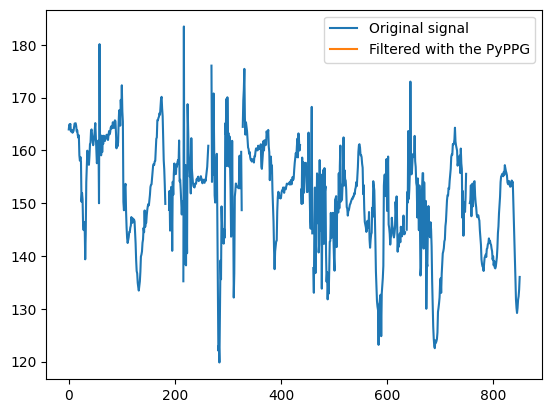

ERROR:root:Excpetion at peak identification: negative dimensions are not allowed, Traceback (most recent call last):
  File "/tmp/ipykernel_87129/796587426.py", line 158, in <module>
    fiducials = detect_peaks(signal)
  File "/tmp/ipykernel_87129/4256704585.py", line 178, in detect_peaks
    vpg_fp = self.get_vpg_fiducials(onsets)
  File "/home/benitez/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/pyPPG/fiducials.py", line 935, in get_vpg_fiducials
    nan_v = np.empty(len(onsets)-1)
ValueError: negative dimensions are not allowed

INFO:root:End of video. Total running time: 57.53759765625
INFO:root:We should have about 900 frames, and we have 851
INFO:root:Final BPM before filtering: 72
INFO:root:Average BPM before filtering: 66
INFO:root:Median BPM after filtering: 0
INFO:root:Real BPM: 116.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 37 (16:16:40)
/home/benitez/.cache/pypoetry/virtualenvs/

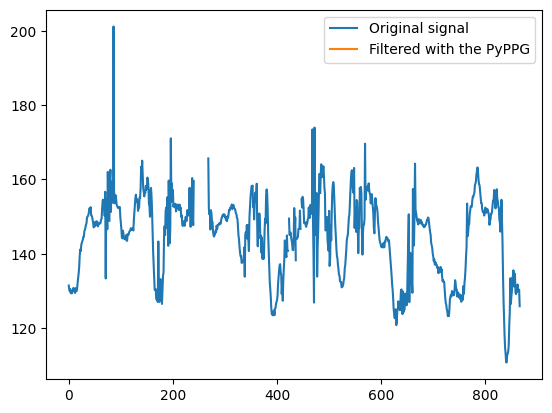

ERROR:root:Excpetion at peak identification: negative dimensions are not allowed, Traceback (most recent call last):
  File "/tmp/ipykernel_87129/796587426.py", line 158, in <module>
    fiducials = detect_peaks(signal)
  File "/tmp/ipykernel_87129/4256704585.py", line 178, in detect_peaks
    vpg_fp = self.get_vpg_fiducials(onsets)
  File "/home/benitez/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/pyPPG/fiducials.py", line 935, in get_vpg_fiducials
    nan_v = np.empty(len(onsets)-1)
ValueError: negative dimensions are not allowed

INFO:root:End of video. Total running time: 58.52478551864624
INFO:root:We should have about 900 frames, and we have 867
INFO:root:Final BPM before filtering: 54
INFO:root:Average BPM before filtering: 67
INFO:root:Median BPM after filtering: 0
INFO:root:Real BPM: 110.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 38 (16:17:32)
/home/benitez/.cache/pypoetry/virtualen

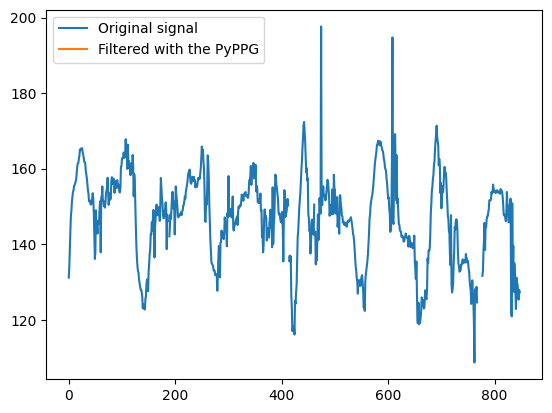

ERROR:root:Excpetion at peak identification: negative dimensions are not allowed, Traceback (most recent call last):
  File "/tmp/ipykernel_87129/796587426.py", line 158, in <module>
    fiducials = detect_peaks(signal)
  File "/tmp/ipykernel_87129/4256704585.py", line 178, in detect_peaks
    vpg_fp = self.get_vpg_fiducials(onsets)
  File "/home/benitez/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/pyPPG/fiducials.py", line 935, in get_vpg_fiducials
    nan_v = np.empty(len(onsets)-1)
ValueError: negative dimensions are not allowed

INFO:root:End of video. Total running time: 56.61062407493591
INFO:root:We should have about 900 frames, and we have 848
INFO:root:Final BPM before filtering: 90
INFO:root:Average BPM before filtering: 66
INFO:root:Median BPM after filtering: 0
INFO:root:Real BPM: 107.0


In [3]:
data = pd.read_csv("assets/data.csv", index_col='N')
data['HR_predicted'] = np.NaN
data['points_sp'] = json.dumps([])
data['points_dn'] = json.dumps([])

for index, row in data.iterrows():
    if pd.isna(row['Recording']):
        continue
    #if index<16:
    #    continue

    ###########################################################
    # Extract signal from face
    ###########################################################
    #cap = cv2.VideoCapture("assets/video_3.mp4")
    logging.info('-'*50)
    logging.info(f"\nReading video {index} ({row['Recording']})")
    cap = cv2.VideoCapture(f"assets/video/{row['Recording']}.mp4")
    #cap = cv2.VideoCapture(f"assets/video/15:53:33.mp4")

    
    fu = Face_utilities()
    sp = Signal_processing()
    
    i=0
    
    
    t = time.time()
    
    #for signal_processing
    BUFFER_SIZE = 100
    
    fps=0 #for real time capture
    video_fps = cap.get(cv2.CAP_PROP_FPS) # for video capture
    #print(video_fps)
    
    times: list = []  # size: 1 x BUFFER_SIZE
    data_buffer: list = []  # size: 1 x BUFFER_SIZE
    data_buffer_all: list = []  # size: 1 x videoFrames
    filtered_data = []  # size: 1 x BUFFER_SIZE
    fft_of_interest = []
    freqs_of_interest = []
    
    bpm = 0
    bpm_all = []  # size: 1 x videoFrames
    
    
    
    while True:
        # grab a frame -> face detection -> crop the face -> 68 facial landmarks -> get mask from those landmarks
        t0 = time.time()    
        ret, frame = cap.read()
        
        if frame is None:
            break
        
        ret_process = fu.no_age_gender_face_process(frame, "68")
        
        if ret_process is None:
            logging.warning("No face detected")
            continue
        
        rects, face, shape, aligned_face, aligned_shape = ret_process
        
        (x, y, w, h) = face_utils.rect_to_bb(rects[0])
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)

        if(len(aligned_shape)==68):
            cv2.rectangle(aligned_face,(aligned_shape[54][0], aligned_shape[29][1]), #draw rectangle on right and left cheeks
                    (aligned_shape[12][0],aligned_shape[33][1]), (0,255,0), 0)
            cv2.rectangle(aligned_face, (aligned_shape[4][0], aligned_shape[29][1]), 
                    (aligned_shape[48][0],aligned_shape[33][1]), (0,255,0), 0)
        else:
            cv2.rectangle(aligned_face, (aligned_shape[0][0],int((aligned_shape[4][1] + aligned_shape[2][1])/2)),
                        (aligned_shape[1][0],aligned_shape[4][1]), (0,255,0), 0)
            
            cv2.rectangle(aligned_face, (aligned_shape[2][0],int((aligned_shape[4][1] + aligned_shape[2][1])/2)),
                        (aligned_shape[3][0],aligned_shape[4][1]), (0,255,0), 0)
        
        for (x, y) in aligned_shape: 
            cv2.circle(aligned_face, (x, y), 1, (0, 0, 255), -1)
            
            
        #for signal_processing
        ROIs = fu.ROI_extraction(aligned_face, aligned_shape)
        green_val = sp.extract_color(ROIs)
        logging.debug(green_val)
        
        data_buffer.append(green_val)
        data_buffer_all.append(green_val)
        
        times.append((1.0/video_fps)*i)
        
        L = len(data_buffer)
        if L <= BUFFER_SIZE:
            cv2.putText(frame, "Filling up buffer...", (30,int(frame.shape[0]*0.95)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        else:
            data_buffer = data_buffer[-BUFFER_SIZE:]
            times = times[-BUFFER_SIZE:]
            fps = float(BUFFER_SIZE) / (times[-1] - times[0])
            cv2.putText(frame, "fps: {0:.2f}".format(fps), (30,int(frame.shape[0]*0.85)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            detrended_data = sp.signal_detrending(data_buffer)
            interpolated_data = sp.interpolation(detrended_data, times)
            normalized_data = sp.normalization(interpolated_data)
            
            fft_of_interest, freqs_of_interest = sp.fft(normalized_data, fps)
            max_arg = np.argmax(fft_of_interest)
            bpm = freqs_of_interest[max_arg]
            cv2.putText(frame, "HR_real: {0:.2f}".format(row['HR']), (30,int(frame.shape[0]*0.90)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            cv2.putText(frame, "HR_predicted: {0:.2f}".format(bpm), (30,int(frame.shape[0]*0.95)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            filtered_data = sp.butter_bandpass_filter(interpolated_data, (bpm-20)/60, (bpm+20)/60, fps, order = 3)
            
        bpm_all.append(bpm)
    
        # display
        cv2.imshow("frame",frame)
        cv2.imshow("face",aligned_face)
        i = i+1
        logging.debug("time of the loop number "+ str(i) +" : " + str(time.time()-t0))
        
        # waitKey to show the frame and break loop whenever 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    ###########################################################
    # Extract fiducials from signal
    ###########################################################
    assert len(data_buffer) == 100
    assert len(bpm_all) == len(data_buffer_all)
    assert fps > 20
    # Load into PyPPG
    # TODO:
    # Dear PyPPG maintainers: please document that `load_data` expects a mat file
    # And that the mat file should contain a field `Data` with a 1d array, and a field `Fs` with the sampling rate.
    with tempfile.NamedTemporaryFile(suffix='.mat') as temp:
        scipy.io.savemat(temp.name, {
            'Data': data_buffer_all,
            'Fs': fps,
        })
        signal = load_data(data_path=temp.name, fs=0, start_sig=0, end_sig=-1, channel="Pleth", use_tk=True, print_flag=True)

    filtered = filter_ppg(signal, verbose=False)

    # Plot in time domain
    points_to_plot = 2000
    filtered = filtered[:points_to_plot-740]
    plt.plot(signal.v[:points_to_plot], label='Original signal')
    plt.plot(filtered[:points_to_plot], label='Filtered with the PyPPG')
    plt.legend()
    plt.show()

    # peak detection
    signal.ppg = filtered
    try:
        fiducials = detect_peaks(signal)
        plot_peaks(signal, fiducials, 'Fiducial detection')
        assert type(fiducials) == pd.DataFrame
        assert fiducials.shape[0] > 5
    except Exception as e:
        logging.error(f'Excpetion at peak identification: {e}, {traceback.format_exc()}')
        fiducials = None

    ###########################################################
    # Analysis
    ###########################################################

    #plt.plot(data_buffer_all)
    #plt.title(f"Detection for recording {row['Recording']}")
    #plt.show()
    
    #plt.plot(bpm_all)
    #plt.show()

    if fiducials is not None:
        print('????????????????')
        # Take bpm by the median number of frames between two consecutive systolic peaks
        median_bpm = int(fiducials['sp'].diff().median() * 60 / fps)
        points_sp = (fiducials['sp']/fps).astype(float).tolist()
        points_dn = (fiducials['dn']/fps).astype(float).tolist()
        data.loc[index, 'HR_predicted'] = median_bpm
    else:
        #plot_peaks(signal, pd.DataFrame(columns=['on', 'sp', 'dn', 'dp', 'off', 'u', 'v', 'w', 'a', 'b', 'c', 'd', 'e', 'f', 'p1', 'p2']), 'Fiducial detection')
        median_bpm = 0
        points_sp = []
        points_dn = []
        # TODO: reestimate fft from filtered signal
        data.loc[index, 'HR_predicted'] = int(np.mean(bpm_all[BUFFER_SIZE:]))
    data.loc[index, 'points_sp'] = json.dumps(points_sp)
    data.loc[index, 'points_dn'] = json.dumps(points_dn)

    logging.info("End of video. Total running time: " + str(time.time() - t))
    logging.info(f"We should have about {int(video_fps*30)} frames, and we have {len(bpm_all)}")
    logging.info(f"Final BPM before filtering: {int(bpm_all[-1])}")
    logging.info(f"Average BPM before filtering: {int(np.mean(bpm_all[BUFFER_SIZE:]))}")
    logging.info(f"Median BPM after filtering: {median_bpm}")
    logging.info(f"Real BPM: {row['HR']}")

    pd.DataFrame(
        data_buffer_all,
        index=pd.Series(np.arange(0, (1/fps)*len(data_buffer_all), 1/fps), name='time'),
        columns=['signal'],
    ).to_csv(f"assets/ecg_from_video/{row['Recording']}.csv")
    
    
    #break
    #if index >= 2:
    #    break



In [4]:
data

,Condition,Subject,Recording,HR,HR_predicted,points_sp,points_dn
N,,,,,,,
1,Neutral,Adam,15:50:04,100.0,73.0,"[0.593993093023256, 2.342972755813954, 3.69595...","[0.8249904069767444, 2.5739700697674426, 3.959..."
2,Neutral,Adam,15:53:33,101.0,73.0,"[1.3199883700440525, 2.0789816828193826, 3.167...","[1.3529880792951536, 2.1119813920704837, 3.233..."
3,Neutral,NaN,NaN,NaN,NaN,[],[]
4,Neutral,NaN,NaN,NaN,NaN,[],[]
5,Neutral,NaN,NaN,NaN,NaN,[],[]
6,Illumination variation,Adam,15:55:30,129.0,114.0,"[1.3529790696132593, 3.00295354475138, 5.34591...","[1.484977027624309, 3.1679509922651925, 5.4119..."
7,Illumination variation,Adam,15:58:54,128.0,81.0,"[2.4089687142857135, 3.2669575714285704, 4.586...","[2.507967428571428, 3.3329567142857135, 4.6529..."
8,Illumination variation,NaN,NaN,NaN,NaN,[],[]
9,Illumination variation,NaN,NaN,NaN,NaN,[],[]


In [5]:
data.to_csv("assets/data_predicted.csv", quoting=csv.QUOTE_ALL)

In [6]:
'''
wtf = pd.read_csv(f"assets/ecg_from_video/15:50:04.csv")
with tempfile.NamedTemporaryFile(suffix='.mat') as temp:
    scipy.io.savemat(temp.name, {
        'Data': wtf['signal'].values,
        'Fs': wtf['time'].shape[0] / (wtf['time'].iloc[-1] - wtf['time'].iloc[0]),
    })
    signal = load_data(data_path=temp.name, fs=0, start_sig=0, end_sig=-1, channel="Pleth", use_tk=True, print_flag=True)
''';